Libraries

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
np.random.seed(0)
torch.manual_seed(0)
df = pd.read_csv("files/fashion-mnist_train.csv")
test_df = pd.read_csv("files/fashion-mnist_test.csv")

train_labels = df['label'].to_numpy()
train_pixels = df.drop('label',axis=1).to_numpy()
train_pixels = train_pixels.astype(np.float32)/255.0
train_images = train_pixels.reshape(-1,28,28)

test_labels = test_df['label'].to_numpy()
test_pixels = test_df.drop('label',axis=1).to_numpy()
test_pixels = test_pixels.astype(np.float32)/255.0
test_images = test_pixels.reshape(-1,28,28)

In [14]:
Xtr = torch.from_numpy(train_images[:,None,:,:])
ytr = torch.from_numpy(train_labels)

Xte = torch.from_numpy(test_images[:,None,:,:])
yte = torch.from_numpy(test_labels)

In [15]:
train_loader = DataLoader(TensorDataset(Xtr,ytr), batch_size= 128, shuffle=True)
test_loader = DataLoader(TensorDataset(Xte,yte), batch_size= 128 , shuffle=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=7,padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,64,kernel_size=5,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,10),
        )
    def forward(self,x):
        x = self.conv(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x


In [18]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4,weight_decay=1e-5)

In [19]:
def translate_label(label):
    if label == 0:
        return "T-shirt/top"
    elif label == 1:
        return "Trouser"
    elif label == 2:
        return "Pullover"
    elif label == 3:
        return "Dress"
    elif label == 4:
        return "Coat"
    elif label == 5:
        return "Sandal"
    elif label == 6:
        return "Shirt"
    elif label == 7:
        return "Sneaker"
    elif label == 8:
        return "Bag"
    else:
        return "Ankle boot"


def accuracy(loader,final=None):
    
    if final:
        y_true = np.array([])
        y_pred = np.array([])
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            if final:
                y_true = np.append(y_true, [translate_label(int(l)) for l in yb.cpu().numpy()])
                y_pred = np.append(y_pred, [translate_label(int(p)) for p in pred.cpu().numpy()])
    if final:
        return correct/total,y_true,y_pred
        
    return correct / total

In [20]:
train_losses = []
test_loss = []
test_acc = []
for epoch in range(1,21):
    model.train()
    running = 0.0
    for xb,yb in train_loader:
        xb,yb = xb.to(device),yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits,yb)
        loss.backward()
        optimizer.step()
        running+= loss.item()*xb.size(0)
    tr_loss = running / len(train_loader.dataset)

    accs = accuracy(test_loader)
    test_acc.append(accs)
    train_losses.append(tr_loss)
    model.eval()
    test_running = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            test_running += loss.item() * xb.size(0)
    te_loss = test_running / len(test_loader.dataset)
    test_loss.append(te_loss)

    print(f"epoch# {epoch} ; train loss = {tr_loss:.4f} ; test loss = {te_loss:.4f}; test_acc = {accs:.3f}")
acc,y_true,y_pred = accuracy(test_loader,True)
print(f"Final test accuracy: {acc:.3f}")

epoch# 1 ; train loss = 0.7394 ; test loss = 0.4229; test_acc = 0.851
epoch# 2 ; train loss = 0.4242 ; test loss = 0.3349; test_acc = 0.878
epoch# 3 ; train loss = 0.3669 ; test loss = 0.2975; test_acc = 0.891
epoch# 4 ; train loss = 0.3330 ; test loss = 0.2839; test_acc = 0.899
epoch# 5 ; train loss = 0.3098 ; test loss = 0.2938; test_acc = 0.892
epoch# 6 ; train loss = 0.2922 ; test loss = 0.2831; test_acc = 0.896
epoch# 7 ; train loss = 0.2788 ; test loss = 0.2662; test_acc = 0.903
epoch# 8 ; train loss = 0.2672 ; test loss = 0.2460; test_acc = 0.909
epoch# 9 ; train loss = 0.2569 ; test loss = 0.2509; test_acc = 0.908
epoch# 10 ; train loss = 0.2456 ; test loss = 0.2679; test_acc = 0.900
epoch# 11 ; train loss = 0.2350 ; test loss = 0.2382; test_acc = 0.912
epoch# 12 ; train loss = 0.2285 ; test loss = 0.2379; test_acc = 0.912
epoch# 13 ; train loss = 0.2221 ; test loss = 0.2585; test_acc = 0.903
epoch# 14 ; train loss = 0.2126 ; test loss = 0.2354; test_acc = 0.912
epoch# 15 ; tra

['Sneaker' 'Ankle boot' 'Ankle boot' ... 'Shirt' 'Dress' 'Bag']


<Figure size 720x360 with 0 Axes>

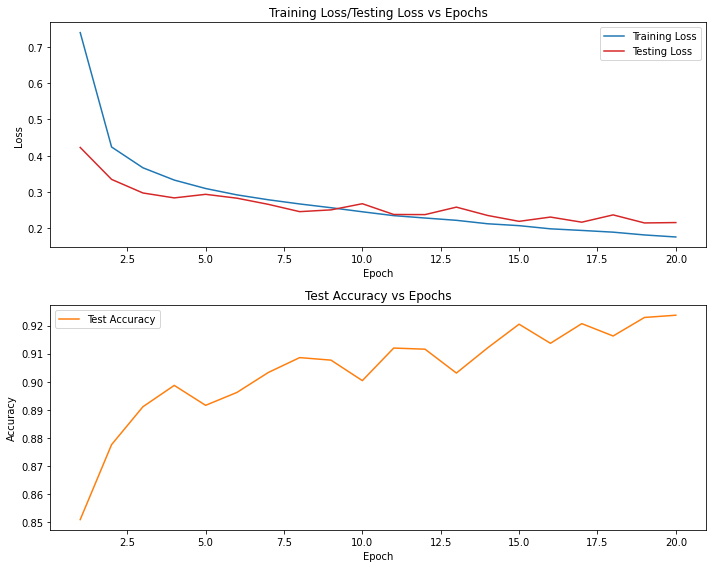

Confusion Matrix:
 [[820   0  18  16   1   1 140   0   4   0]
 [  0 991   1   7   0   0   1   0   0   0]
 [  7   0 878  16  44   0  53   0   2   0]
 [  8   2   2 962   9   0  16   0   0   1]
 [  0   0  39  34 856   0  71   0   0   0]
 [  0   0   0   0   0 980   1  12   0   7]
 [ 58   0  41  25  36   0 836   0   4   0]
 [  0   0   0   0   0   8   0 954   0  38]
 [  2   2   1   3   1   0   4   1 985   1]
 [  0   0   0   0   0   3   0  22   0 975]]


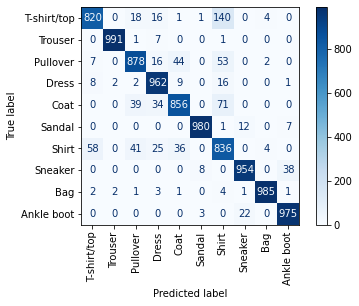

In [21]:
print(y_pred)
epochs = range(1,21)
plt.figure(figsize=(10,5))

plt.figure(figsize=(10,8))

# --- Training loss plot ---
plt.subplot(2, 1, 1)  # (rows, cols, index)
plt.plot(epochs, train_losses, label="Training Loss", color="tab:blue")
plt.plot(epochs, test_loss, label="Testing Loss", color="tab:red")
plt.title("Training Loss/Testing Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# --- Test accuracy plot ---
plt.subplot(2, 1, 2)
plt.plot(epochs, test_acc, label="Test Accuracy", color="tab:orange")
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true,y_pred,labels=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("Confusion Matrix:\n",cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
disp.plot(cmap='Blues',xticks_rotation=90)